In [1]:
import sys
import torch
sys.path.append("/Users/philippvonbachmann/Documents/University/WiSe2122/ResearchProject/ResearchProjectLLVI/BasicExample")
from src.log_likelihood import LogLikelihoodMonteCarlo
from datasets.Regression.toydataset import create_dataset, sinus_mapping, dataset_to_loader, visualize_predictions, to_loader
from src.network.feature_extractor import FC_Net
from src.network import LikApprox
from torch import nn
from backpack import backpack, extend
from backpack.extensions import DiagHessian, DiagGGNExact, DiagGGNMC
from torch.autograd import grad
from tqdm import tqdm
from src.laplace import LaplaceVI
from matplotlib import pyplot as plt
import copy
from src.network.feature_extractor import FC_Net
from src.network.Regression import LLVIRegressionNoNoise, LLVIRegression
from src.weight_distribution.Diagonal import Diagonal

torch.manual_seed(3)

data_noise = 0.2
n_datapoints=256
x_train, y_train, x_test, y_test = create_dataset(lower=-5, upper=7, mapping=sinus_mapping,cluster_pos=[-0.5, 2], data_noise=data_noise, n_datapoints=n_datapoints)
batch_size = 16
train_set, test_set = dataset_to_loader(x_train, y_train, x_test, y_test , batch_size=16)

### params

In [2]:
tau = 0.1
lr = 1e-4
optimizer = torch.optim.SGD
epochs = 500

### Laplace Model

In [3]:
feature_extractor = torch.nn.Sequential(
        torch.nn.Linear(1, 100),
        torch.nn.Tanh(),
        torch.nn.Linear(100, 200),
        torch.nn.Tanh()
)
la_model = LaplaceVI(200, 1, feature_extractor, tau=tau, lr=lr)

### VI model

In [4]:
dist = Diagonal(200, 1, lr=lr, init_log_var=-2)
dist.update_mean(la_model.ll_model[-1].weight.T)
vi_feature_extractor = FC_Net(layers=[1, 100, 200], nll = torch.nn.Tanh(),lr=lr, weight_decay=0, optimizer=optimizer)
vi_feature_extractor.load_state_dict(feature_extractor.state_dict(), strict=False)
# vi_feature_extractor.optimizer = torch.optim.SGD(vi_feature_extractor.parameters(), lr=1e-3)
vi_model = LLVIRegressionNoNoise(200, 1, vi_feature_extractor, dist, prior_log_var=0, optimizer_type=optimizer,
tau=tau,
lr=lr)

Make sure that copying worked

In [5]:
for data, target in train_set:
    y_la_mean, _ = la_model.predict(data)
    y_vi_mean, _ = vi_model.predict(data)
    assert torch.equal(y_la_mean, y_vi_mean)

Now we can train

In [6]:
# vi_model.train_without_VI(train_set, n_datapoints)

In [7]:
vi_tracking, vi_trajectories = vi_model.train_model_log_trajectories(train_set, n_datapoints=n_datapoints, epochs=epochs, method=LikApprox.MONTECARLO, samples=1)

prediction_loss:0.48 kl_loss:0.05: 100%|██████████| 500/500 [00:33<00:00, 14.96it/s]


In [8]:
la_tracking, la_trajectories = la_model.train_model_with_trajectories(train_set, n_datapoints, epochs);

loss:0.32 entropy:294.49: 100%|██████████| 500/500 [00:35<00:00, 14.12it/s]


plot the kl divergence

In [9]:
def kl_divergence(mu_1, cov_1, mu_2, cov_2):
    assert mu_1.shape == mu_2.shape and cov_1.shape == cov_2.shape
    first_term = torch.sum(torch.log(cov_2) - torch.log(cov_1))
    second_term = torch.sum(torch.div(cov_1, cov_2))
    last_term = torch.sum(torch.div(torch.square(mu_2 - mu_1), cov_2))
    # print(first_term, second_term, last_term)
    div = 0.5 * (first_term - mu_1.shape[0] + second_term + last_term)
    return div

In [10]:
kl_divergence(dist.get_mu().flatten(), dist.get_cov().diag(), la_model.ll_model[-1].weight.flatten(), la_model.covariance_matrix.flatten())

tensor(53441.9258, grad_fn=<MulBackward0>)

the weight space

In [11]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import torch

def plot_trajectories(traj, axs, splits, labels=("Laplace", "VI"), color=["red", "blue"]):
    pca = PCA(n_components=2)
    projection = pca.fit_transform(traj)
    for idx, (start, end) in enumerate(zip([0]+splits, splits+[traj.shape[0]])):
        # axs.scatter(projection[start:end, 0], projection[start:end, 1], s=10, label=labels[idx])
        axs.plot(projection[start:end, 0], projection[start:end, 1], label=labels[idx], color=color[idx])
        mid = start+int((end-start)/2)
        axs.arrow(projection[mid][0], projection[mid][1], (projection[mid+1] - projection[mid])[0], (projection[mid+1] - projection[mid])[1])
    return pca, projection


(-0.03947402500263225, 0.07552463752265881)

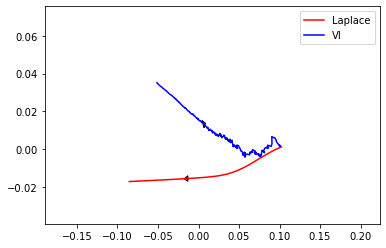

In [12]:
fig, axs = plt.subplots(1)
pca, projection = plot_trajectories(torch.cat([la_trajectories, vi_trajectories], dim=0), axs,
 splits = [epochs], labels=["Laplace", "VI"]);
axs.legend()
axs.set_xlim(axs.get_xlim()[0]*2, axs.get_xlim()[1]*2)
axs.set_ylim(axs.get_ylim()[0]*2, axs.get_ylim()[1]*2)

add the variance

In [13]:
from matplotlib.patches import Ellipse
vi_cov_pca = pca.transform(dist.get_cov().diagonal().unsqueeze(dim=0).detach().numpy()).squeeze()
print(vi_cov_pca)
vi_cov_pca = Ellipse(projection[-1], vi_cov_pca[0], vi_cov_pca[1], color="blue", alpha=0.1)
axs.add_patch(vi_cov_pca)

[0.41684022 1.10051925]


In [14]:
la_cov_pca = pca.transform(la_model.covariance_matrix.detach().numpy()).squeeze()
print(vi_cov_pca)
la_cov_pca = Ellipse(projection[epochs-1], la_cov_pca[0], la_cov_pca[1], color="red", alpha=0.1)
axs.add_patch(la_cov_pca)

Ellipse(xy=(-0.051358831434808, 0.035148712794845514), width=0.4168402175474404, height=1.1005192493068536, angle=0)


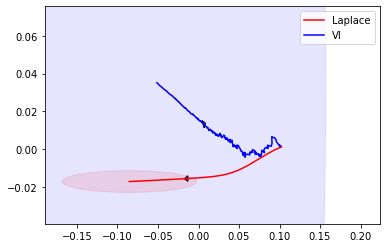

In [15]:
fig